In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from model import _build_model, _build_simple_model, _build_simple_model2
from model_reduced import _build_model, _build_simple_model, _build_simple_model2, _build_reduced_model, _build_reduced_model2
from corex import Graph

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [2]:
model =keras.models.load_model('reduced_modelxe_universal') 
# only for planning use, ignore the trianing warnning below

In [23]:
# initialize env
import itertools
from corex import Graph
action_dict = list(itertools.product(np.round(np.arange(-0.1,0.15,0.05), decimals=2), \
                                     np.round(np.arange(-3,4,1), decimals=0)))

In [24]:
# env=Graph()
# timesteps = 10
# state = env.reset()
# for timestep in range(timesteps):
#     subject_tensor = tf.convert_to_tensor(state[0])
#     subject_tensor = tf.expand_dims(subject_tensor, 0)

#     veh_tensor = tf.convert_to_tensor(state[1])  
#     veh_tensor = tf.expand_dims(veh_tensor, 0)

#     ped_tensor = tf.convert_to_tensor(state[2])  
#     ped_tensor = tf.expand_dims(ped_tensor, 0)

#     cyc_tensor = tf.convert_to_tensor(state[3])  
#     cyc_tensor = tf.expand_dims(cyc_tensor, 0)

#     edge_tensor = tf.convert_to_tensor(state[4])   
#     edge_tensor = tf.expand_dims(edge_tensor, 0) 

#     # state_tensor = tf.expand_dims(state_tensor, 0)
#     state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
#     action_probs = model(state_tensor, training=False)
#     # Take best action
#     action = tf.argmax(action_probs[0]).numpy()
#     state_next, reward, done, _ = env.step(action)
#     print(action, action_dict[action], reward,done, _)
#     state = state_next
# print(env.target.history)

In [167]:
env2=Graph()
timesteps = 10
state = env2.reset()
for timestep in range(timesteps):
    subject_tensor = tf.convert_to_tensor(state[0])
    subject_tensor = tf.expand_dims(subject_tensor, 0)

    veh_tensor = tf.convert_to_tensor(state[1])  
    veh_tensor = tf.expand_dims(veh_tensor, 0)

    ped_tensor = tf.convert_to_tensor(state[2])  
    ped_tensor = tf.expand_dims(ped_tensor, 0)

    cyc_tensor = tf.convert_to_tensor(state[3])  
    cyc_tensor = tf.expand_dims(cyc_tensor, 0)

    edge_tensor = tf.convert_to_tensor(state[4])   
    edge_tensor = tf.expand_dims(edge_tensor, 0) 

    # state_tensor = tf.expand_dims(state_tensor, 0)
    state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
    action_probs = model(state_tensor, training=False)
    # Take best action
    print(action_probs)
    print('--------------')
    action = tf.argmax(action_probs[0]).numpy()
    state_next, reward, done, _ = env2.step(action)
   
    print(timestep, action, action_dict[action], reward,done, _)
    if done:
        break
    state = state_next
#     print(state)
    print("====================")
#     if timestep>2:break
print(env2.target.history)

/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


task [[  580.832 -2335.565]
 [  541.207 -2375.318]]
tf.Tensor(
[[0.        2.4901087 2.4838226 2.4908307 0.        0.        0.
  0.        0.        2.506336  2.4991095 2.5147128 2.5020013 2.495299
  0.        2.5120106 2.5212207 2.5158098 0.        0.        0.
  2.5058885 2.5011172 2.5117226 2.4904938 2.4950233 0.        0.
  2.4887183 2.5002022 2.4866154 0.        2.4847345 0.        0.       ]], shape=(1, 35), dtype=float32)
--------------
0 16 (0.0, -1) 1.743339238183614 False feasible
tf.Tensor(
[[0.        2.4901087 2.4838226 2.4908307 0.        0.        0.
  0.        0.        2.506336  2.4991095 2.5147128 2.5020013 2.495299
  0.        2.5120106 2.5212207 2.5158098 0.        0.        0.
  2.5058885 2.5011172 2.5117226 2.4904938 2.4950233 0.        0.
  2.4887183 2.5002022 2.4866154 0.        2.4847345 0.        0.       ]], shape=(1, 35), dtype=float32)
--------------
1 16 (0.0, -1) 0.837833530823754 False feasible
tf.Tensor(
[[0.        2.4901087 2.4838226 2.4908307 0.   

In [168]:
sample = env2.sample
# print(sample)
target_obs = env2.target.traj[:10]
target_planned = np.array(env2.target.history)[:,1:3]

In [169]:
print(target_obs.shape, target_planned.shape)

(10, 2) (10, 2)


### visualize on map 

In [170]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque

In [171]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 200  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and agent_loc.shape[0] > 100:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 100  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and  agent_loc.shape[0] > 100:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()


In [172]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [173]:
junction_lane_merge = np.load('ruixuan/target_scene_index/lane_merge/scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan/target_scene_index/8KfB/scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [174]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [175]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [176]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None,\
                        target_obs=None, planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary['8KfB']['X'][0],grid_boundary['8KfB']['X'][1])
    plt.ylim(grid_boundary['8KfB']['Y'][0],grid_boundary['8KfB']['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    if target_obs is not None:
        plt.plot(target_obs[:,0],target_obs[:,1], c='green',linewidth=1)
    if planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='red',linewidth=1)
    plt.axis('off')
    plt.show()
    

In [177]:
def animate_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None,\
                            cyc=None, target_obs=None, planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    for idx in range(20):
        plt.figure(figsize=(18,18),frameon=False)
        plt.xlim(grid_boundary['8KfB']['X'][0],grid_boundary['8KfB']['X'][1])
        plt.ylim(grid_boundary['8KfB']['Y'][0],grid_boundary['8KfB']['Y'][1])
        for lane in lane_list[intersection_id]:
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='g',linewidth=1,label=lane)
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='g',linewidth=1)
    #         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
        x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
    #     print(x_mesh.shape, y_mesh[:,1])
        plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
        plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
    #     plt.title(intersection_id,fontsize=30)

    
        if veh is not None:
            for traj in veh: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='b',linewidth=1)
        if ped is not None:
            for traj in ped: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='orange',linewidth=1)
        if cyc is not None:
            for traj in cyc: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='cyan',linewidth=1)
                
        if target_obs is not None and planned is not None:
            if idx<10:
                plt.plot(target_obs[:idx,0],target_obs[:idx,1], c='green',linewidth=1)
            else:
                plt.plot(target_obs[:10,0],target_obs[:10,1], c='green',linewidth=1)
                plt.plot(planned[:idx-9,0],planned[:idx-9,1], c='red',linewidth=2)

        plt.axis('off')
        plt.ioff()
        plt.savefig("animation_fig/%s.png" %(str(idx)),  bbox_inches='tight',pad_inches = 0)
#         plt.show()

In [182]:

    
def get_aseq(traj):
    aseq=[]
    for i in range(9,len(traj)-1):
        curr = traj[i+1]
        prev = traj[i]
        prev2= traj[i-1]
        v10 = np.linalg.norm(curr - prev)/0.5
        v9 = np.linalg.norm(prev - prev2)/0.5
        a = (v10-v9)/0.5
        aseq.append(a)
    return aseq
    
def get_jerkness(traj):
    """
    compute the jerkness of the trajectory of 20 points
    """
   
    history_a = get_aseq(traj)
    jerk=[]
    for i in range(1,len(history_a)):
        jerk.append(abs((history_a[i]-history_a[i-1])/0.5))
    return jerk


[4.745850024267305, 5.898661096227535, 5.3175337992605805, 4.694741932540545, 5.130750362780454, 5.352543188900931, 4.836631415749181, 3.7168066679173535, 0.8866748953586452]
[3.294187021904392, 0.5764055359793119, 0.2905636484853673, 0.3113959333615739, 0.21800421512099177, 0.11089641306205777, 0.2579558865758571, 0.5599123739153384]


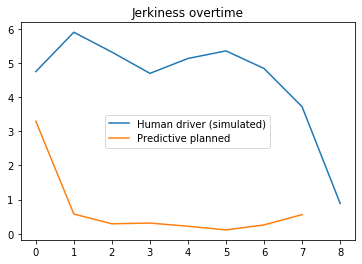

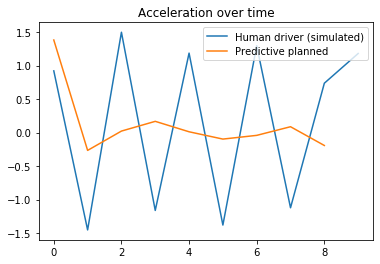

[0 1 2 3 4 5 6 7 8 9]


In [183]:
jerk_human = get_jerkness(env2.target.traj)
print(jerk_human)
jerk_planned = get_jerkness(np.vstack((target_obs, target_planned[1:])))
print(jerk_planned)
x = np.arange(len(jerk_human))
plt.title('Jerkiness overtime')
plt.plot(np.arange(len(jerk_human)), jerk_human, label='Human driver (simulated)')
plt.plot(np.arange(len(jerk_planned)), jerk_planned, label= "Predictive planned")
plt.legend()
plt.savefig('result_fig/jerk')
plt.show()


acc_human = get_aseq(env2.target.traj)
acc_planned = get_aseq(np.vstack((target_obs, target_planned[1:])))
x = np.arange(len(acc_human))
plt.title("Acceleration over time")
plt.plot(np.arange(len(acc_human)), acc_human, label='Human driver (simulated)')
plt.plot(np.arange(len(acc_planned)), acc_planned, label= "Predictive planned")
plt.legend()
plt.savefig('result_fig/acc')
plt.show()



In [210]:
n_cases= 100
all_ah, all_ap, all_jerkh, all_jerkp = [], [],[],[]
finished = 0
while finished<n_cases:
    print(finished)
    timesteps = 10
    state = env2.reset()
    for timestep in range(timesteps):
        subject_tensor = tf.convert_to_tensor(state[0])
        subject_tensor = tf.expand_dims(subject_tensor, 0)
        veh_tensor = tf.convert_to_tensor(state[1])  
        veh_tensor = tf.expand_dims(veh_tensor, 0)
        ped_tensor = tf.convert_to_tensor(state[2])  
        ped_tensor = tf.expand_dims(ped_tensor, 0)
        cyc_tensor = tf.convert_to_tensor(state[3])  
        cyc_tensor = tf.expand_dims(cyc_tensor, 0)
        edge_tensor = tf.convert_to_tensor(state[4])   
        edge_tensor = tf.expand_dims(edge_tensor, 0) 
        # state_tensor = tf.expand_dims(state_tensor, 0)
        state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
        action_probs = model(state_tensor, training=False)
        # Take best action
#         print(action_probs)
#         print('--------------')
        action = tf.argmax(action_probs[0]).numpy()
        state_next, reward, done, _ = env2.step(action)
# 
#         print(timestep, action, action_dict[action], reward,done, _)
        if done:
            break
        state = state_next
    #     print(state)
#         print("====================")
        
    target_obs = env2.target.traj[:10]
    target_planned = np.array(env2.target.history)[:,1:3]
    jerk_human = get_jerkness(env2.target.traj)
    jerk_planned = get_jerkness(np.vstack((target_obs, target_planned[1:])))
    
    acc_human = get_aseq(env2.target.traj)
    acc_planned = get_aseq(np.vstack((target_obs, target_planned[1:])))
    print(len(jerk_planned), len(acc_planned))
    x = np.arange(len(acc_planned))
    if len(x)<10:
        continue
    else:
        all_ah.append(acc_human)
        all_ap.append(acc_planned)
        
        all_jerkh.append(jerk_human)
        all_jerkp.append(jerk_planned)
        finished+=1
       

print('done', np.array(all_ah).shape, np.array(all_jerkp).shape)

0
task [[  541.728 -2403.155]
 [  539.423 -2398.147]]
9 10
1
task [[  538.066 -2402.146]
 [  548.336 -2419.687]]
9 10
2
task [[  545.781 -2410.794]
 [  541.175 -2401.386]]
9 10
3
task [[  594.072 -2309.849]
 [  574.635 -2343.347]]
8 9
3
task [[  543.42  -2406.683]
 [  541.451 -2402.594]]
9 10
4
task [[  555.818 -2367.296]
 [  538.    -2381.207]]
6 7
4
task [[  534.006 -2387.411]
 [  540.211 -2410.349]]
9 10
5
task [[  543.509 -2407.02 ]
 [  540.928 -2401.36 ]]
9 10
6
task [[  542.44  -2402.898]
 [  539.384 -2396.925]]
9 10
7
task [[  473.571 -2406.134]
 [  509.963 -2398.132]]
9 10
8
task [[  644.852 -2239.717]
 [  673.732 -2194.238]]
9 10
9
task [[  539.528 -2398.634]
 [  536.332 -2392.158]]
9 10
10
task [[  558.033 -2365.93 ]
 [  543.147 -2378.138]]
6 7
10
task [[  637.026 -2238.998]
 [  612.849 -2275.85 ]]
8 9
10
task [[  555.352 -2363.771]
 [  502.435 -2394.567]]
9 10
11
task [[  541.261 -2402.082]
 [  539.44  -2397.875]]
0 1
11
task [[  591.012 -2317.687]
 [  574.715 -2344.401]]
7 

8 9
74
task [[  538.725 -2395.979]
 [  537.183 -2387.71 ]]
9 10
75
task [[  574.721 -2371.246]
 [  576.64  -2372.52 ]]
0 1
75
task [[  571.144 -2348.594]
 [  537.686 -2379.066]]
8 9
75
task [[  618.289 -2267.979]
 [  588.322 -2322.114]]
7 8
75
task [[  553.778 -2369.499]
 [  548.266 -2374.315]]
2 3
75
task [[  562.456 -2457.99 ]
 [  572.486 -2478.86 ]]
9 10
76
task [[  641.923 -2231.873]
 [  636.304 -2240.07 ]]
1 2
76
task [[  545.26  -2410.372]
 [  542.542 -2404.458]]
9 10
77
task [[  568.338 -2356.823]
 [  566.254 -2361.2  ]]
0 1
77
task [[  545.693 -2376.332]
 [  532.34  -2390.475]]
8 9
77
task [[  648.705 -2220.98 ]
 [  619.992 -2265.004]]
9 10
78
task [[  591.2   -2318.178]
 [  566.817 -2356.674]]
8 9
78
task [[  542.451 -2378.379]
 [  534.365 -2382.853]]
4 5
78
task [[  542.423 -2404.261]
 [  540.958 -2401.292]]
0 1
78
task [[  638.046 -2242.847]
 [  638.767 -2242.16 ]]
0 1
78
task [[  539.246 -2398.193]
 [  539.247 -2398.131]]
0 1
78
task [[  540.976 -2379.333]
 [  535.787 -2399

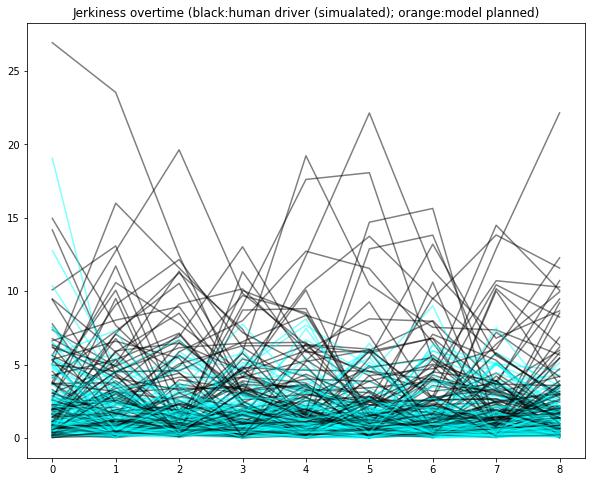

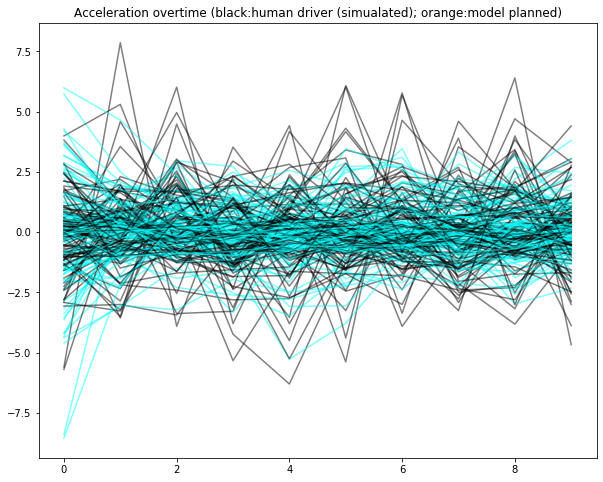

In [214]:
plt.figure(figsize=(10,8))
for jerk_human, jerk_planned in zip(all_jerkh, all_jerkp):

    plt.plot(np.arange(len(jerk_human)), jerk_human, color='k', alpha = 0.5)
    plt.plot(np.arange(len(jerk_planned)), jerk_planned, color='cyan', alpha=0.5 )
plt.title('Jerkiness overtime (black:human driver (simualated); orange:model planned)')
# plt.legend()
plt.savefig('result_fig/jerk_overall')
plt.show()

plt.figure(figsize=(10,8))
for acc_human, acc_planned in zip(all_ah, all_ap):

    plt.plot(np.arange(len(acc_human)), acc_human, color='k', alpha = 0.5)
    plt.plot(np.arange(len(acc_planned)), acc_planned, color='cyan', alpha=0.5 )
plt.title('Acceleration overtime (black:human driver (simualated); orange:model planned)')
# plt.legend()
plt.savefig('result_fig/acc_overall')
plt.show()


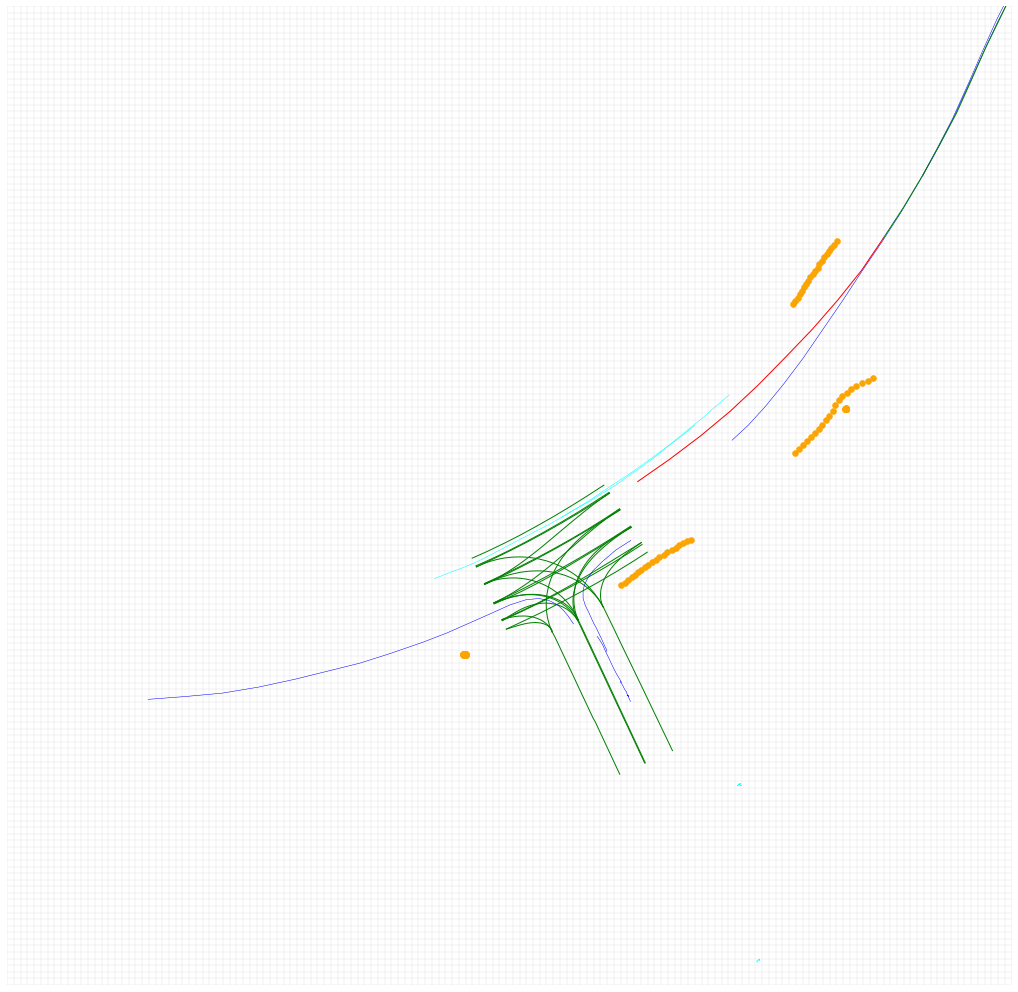

In [180]:
plot_planned_on_grid('8KfB', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=sample['veh'][1:], ped=sample['ped'], cyc=sample['cyc'],
                    target_obs=target_obs, planned=target_planned)

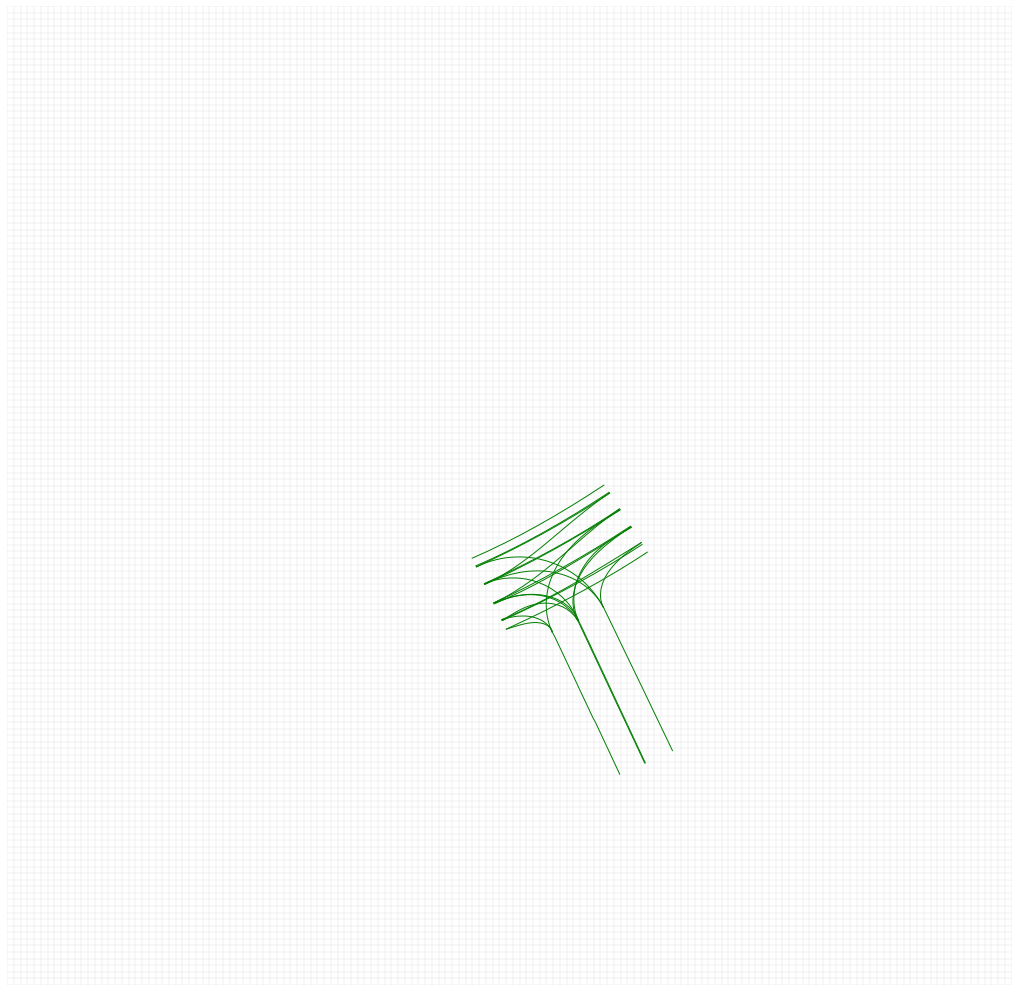

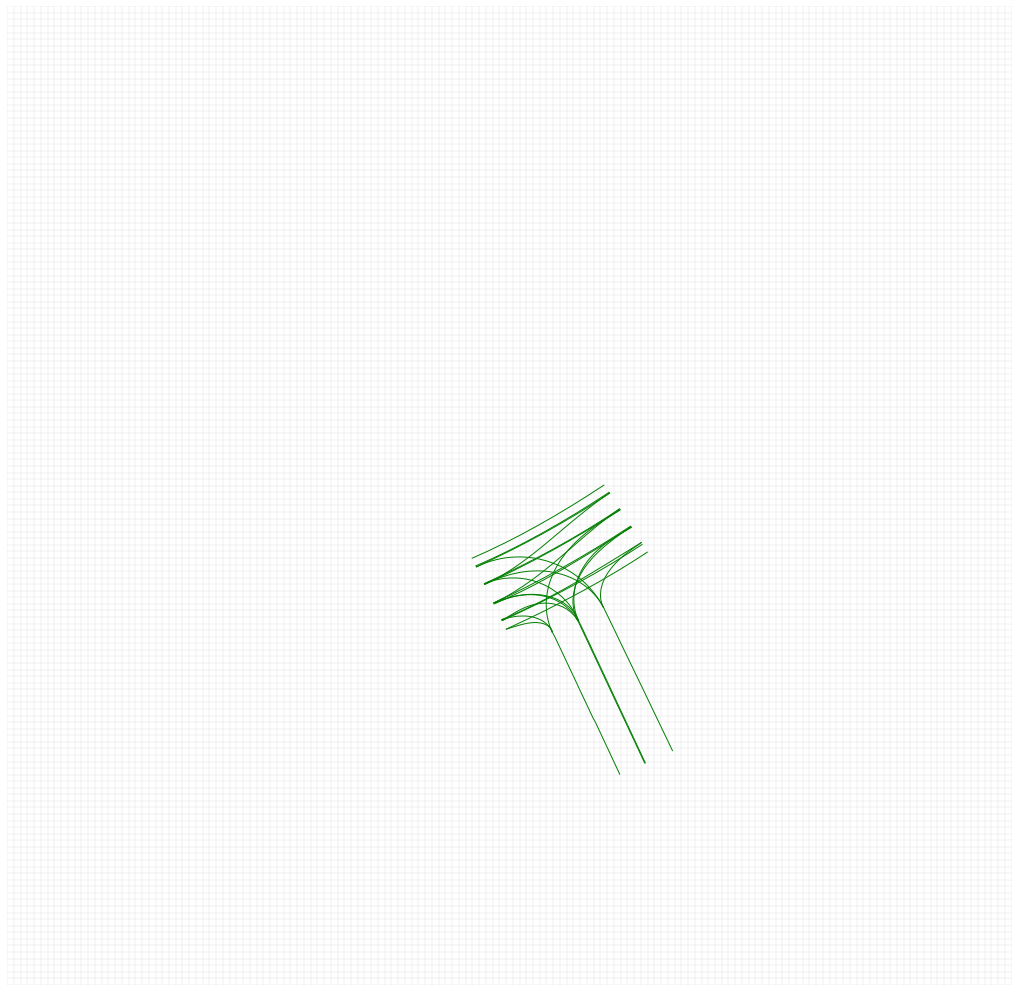

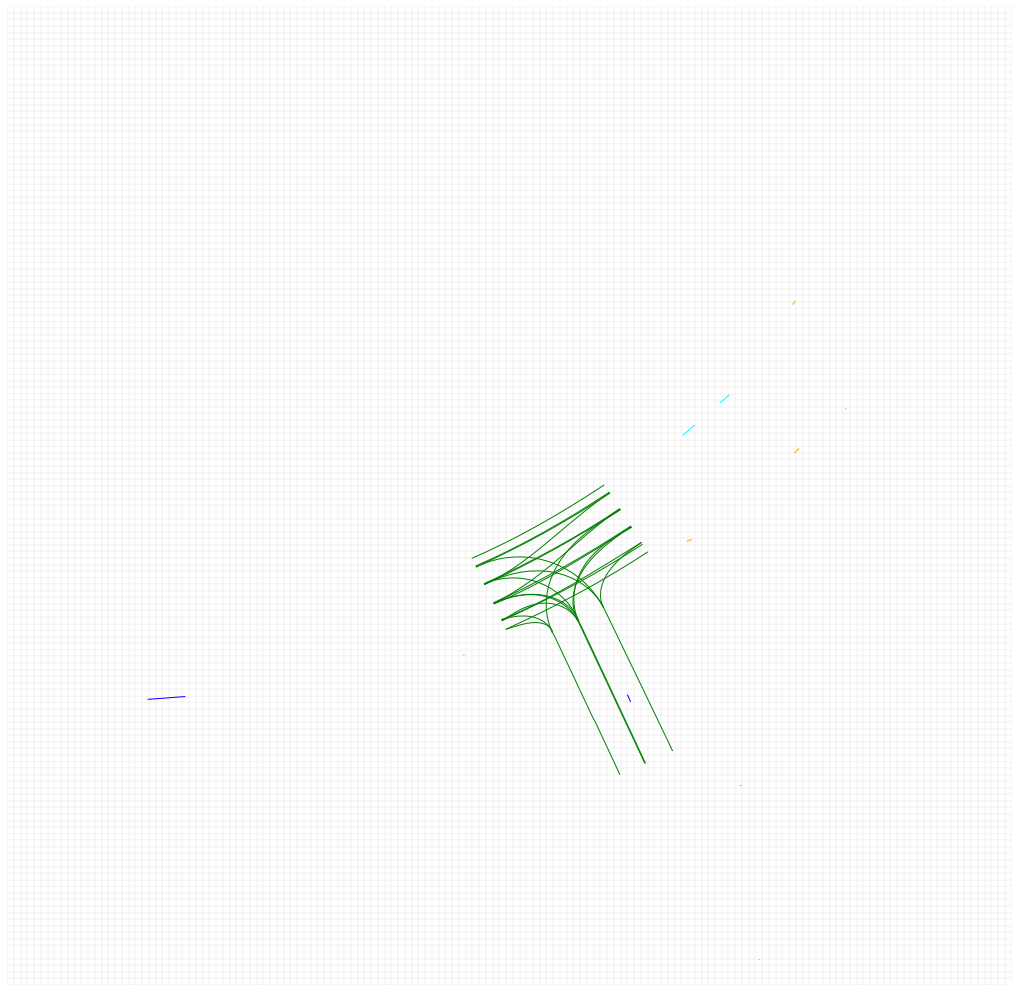

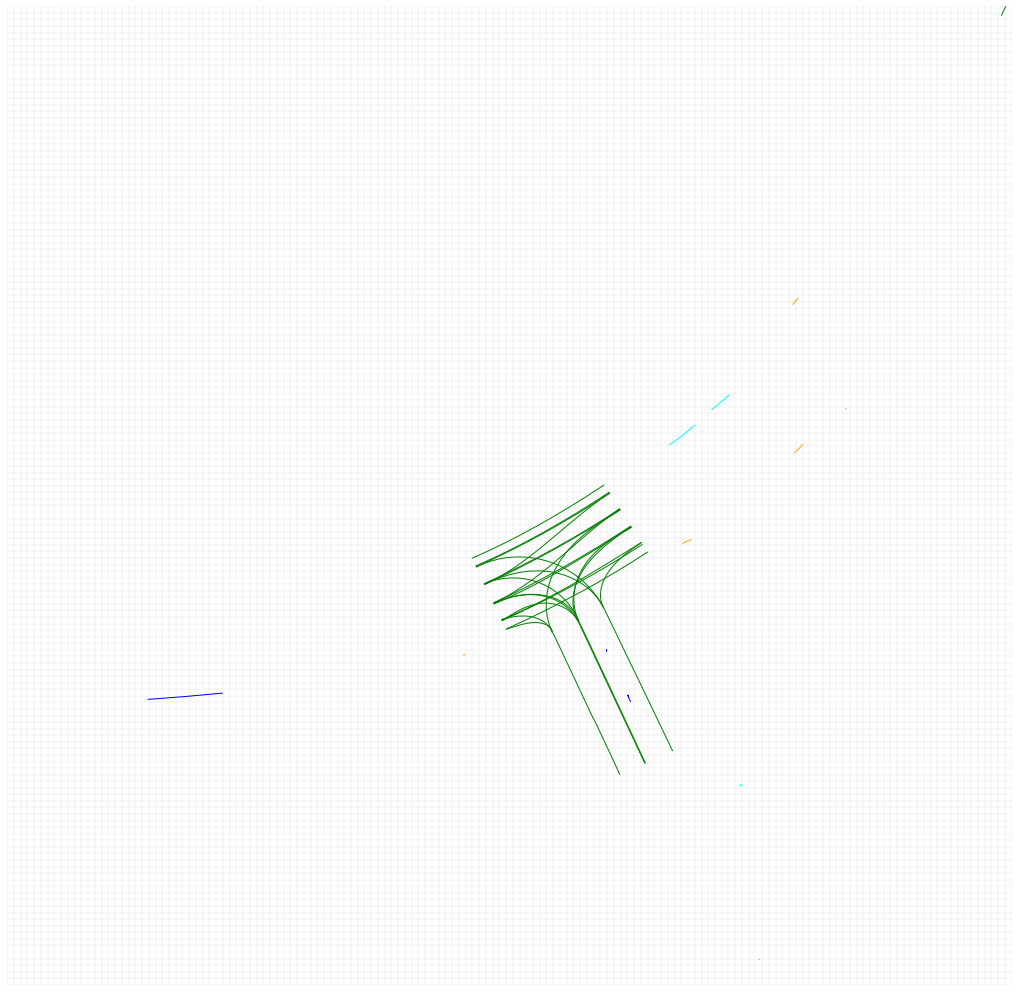

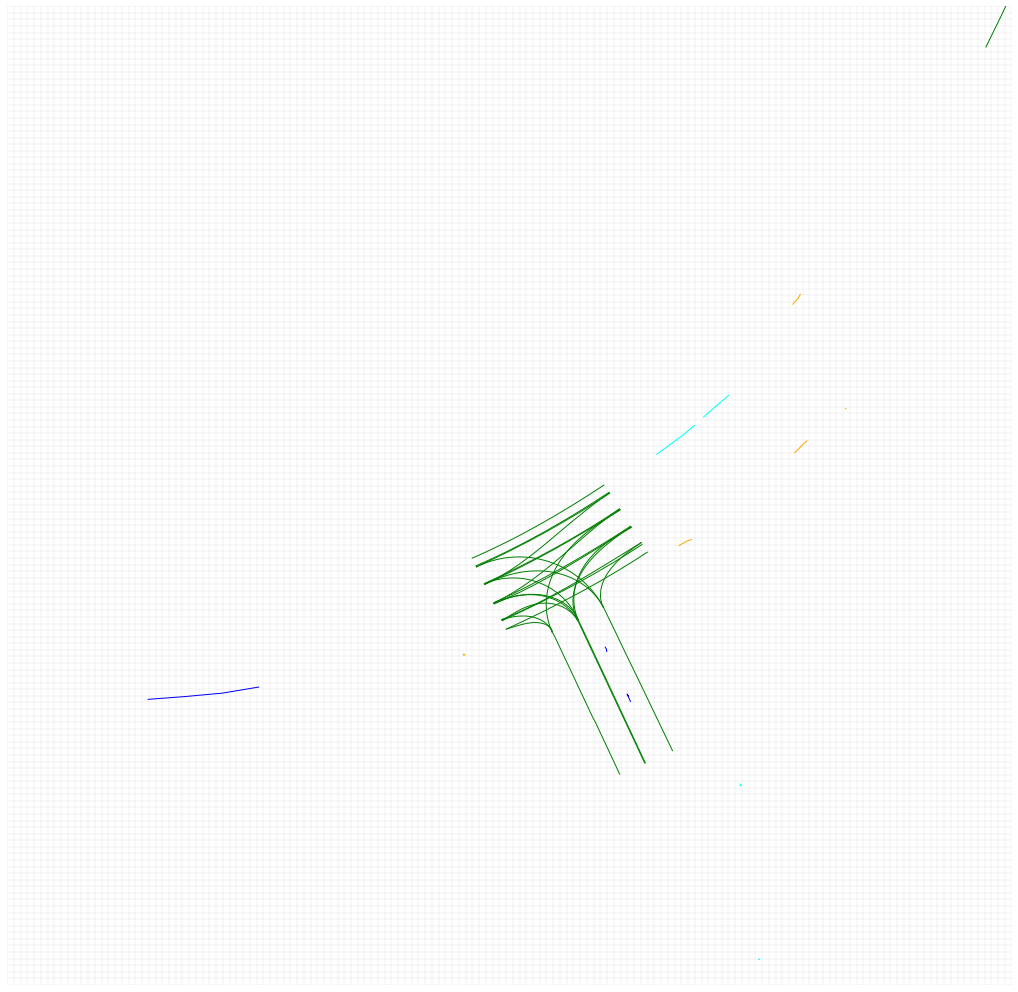

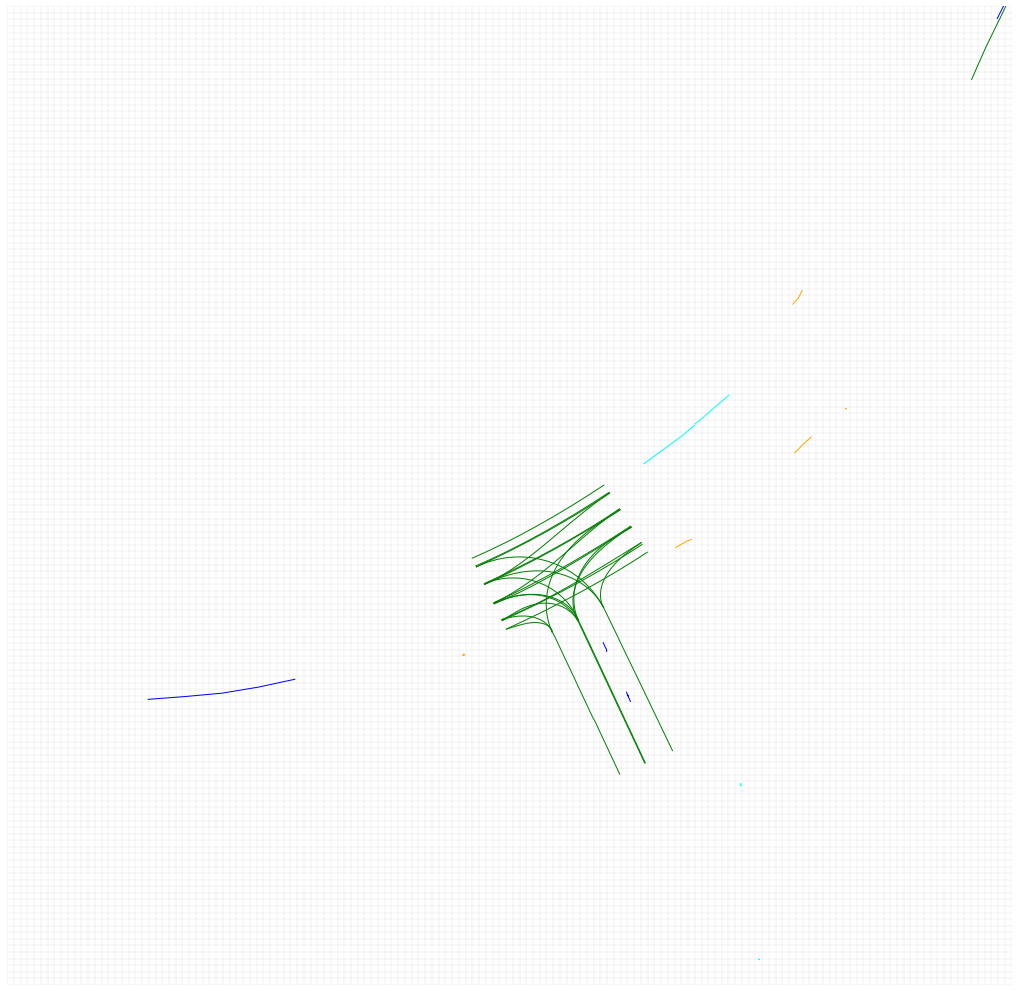

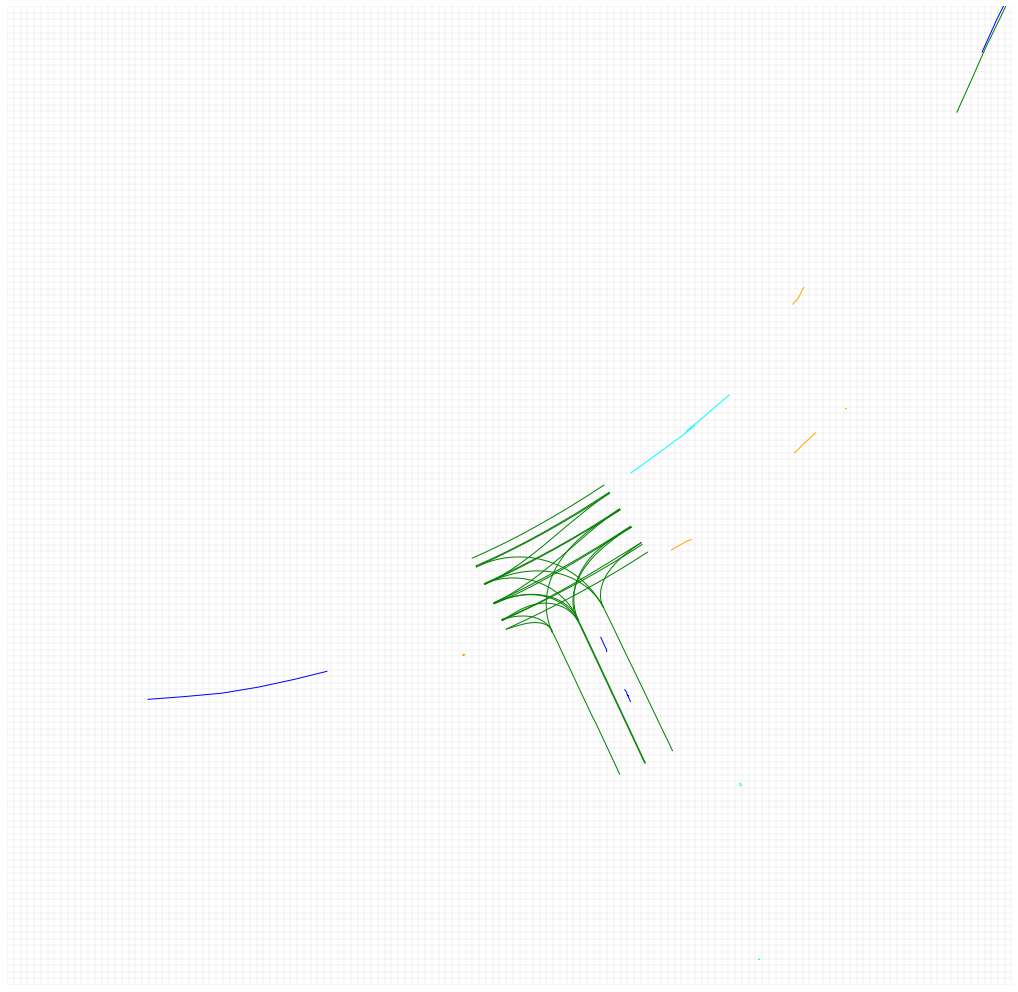

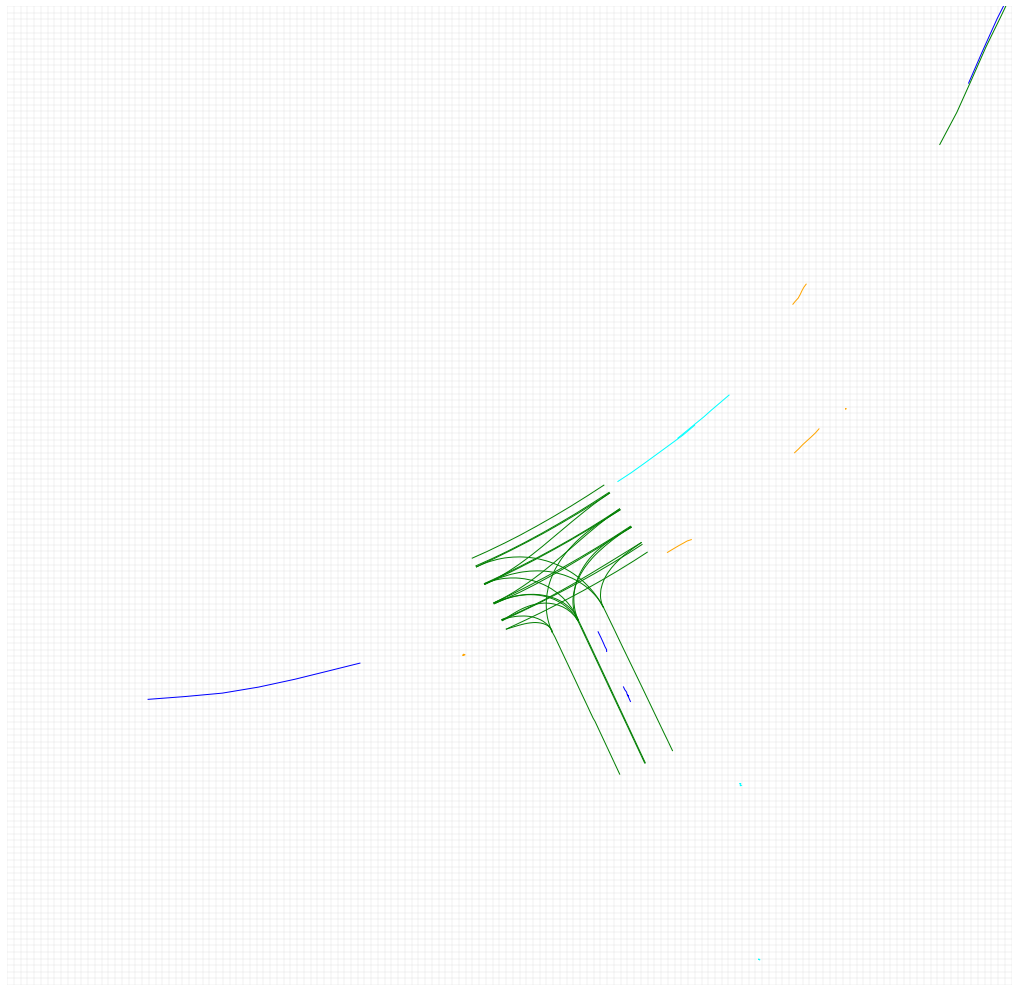

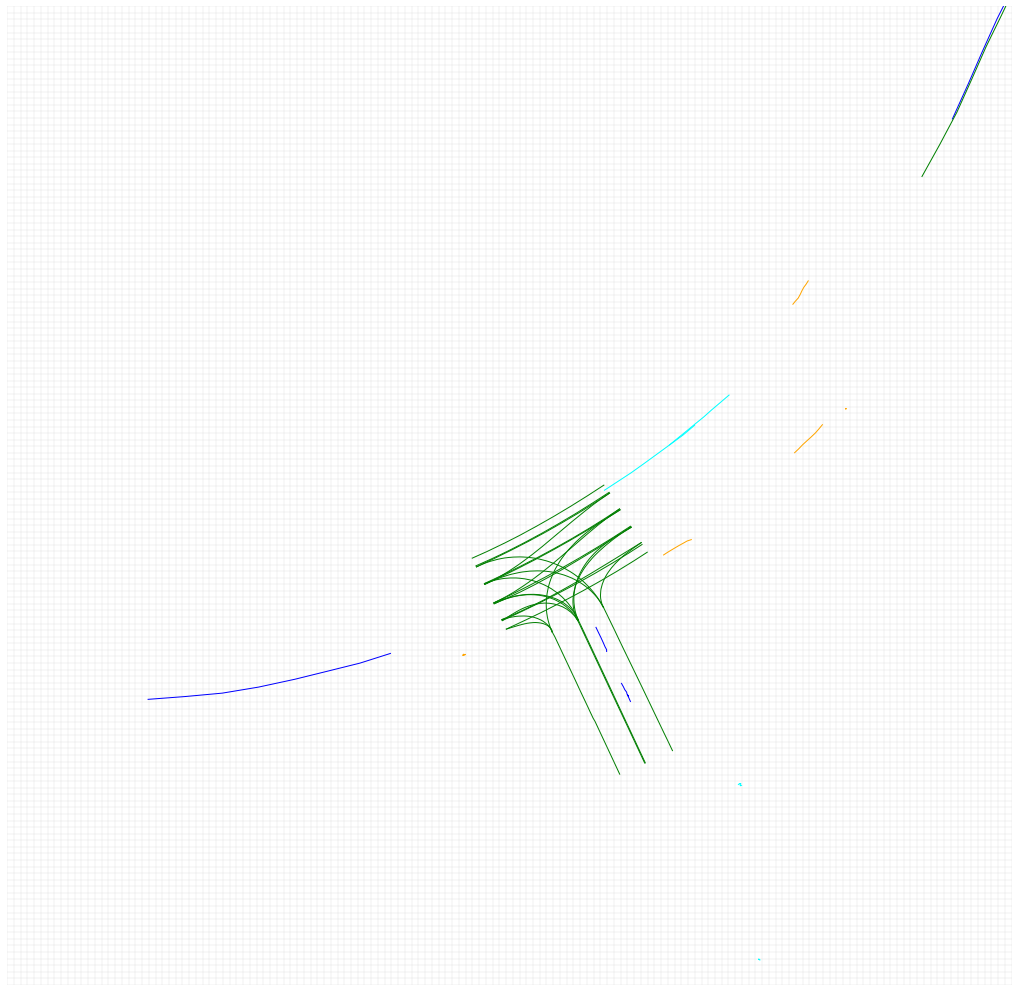

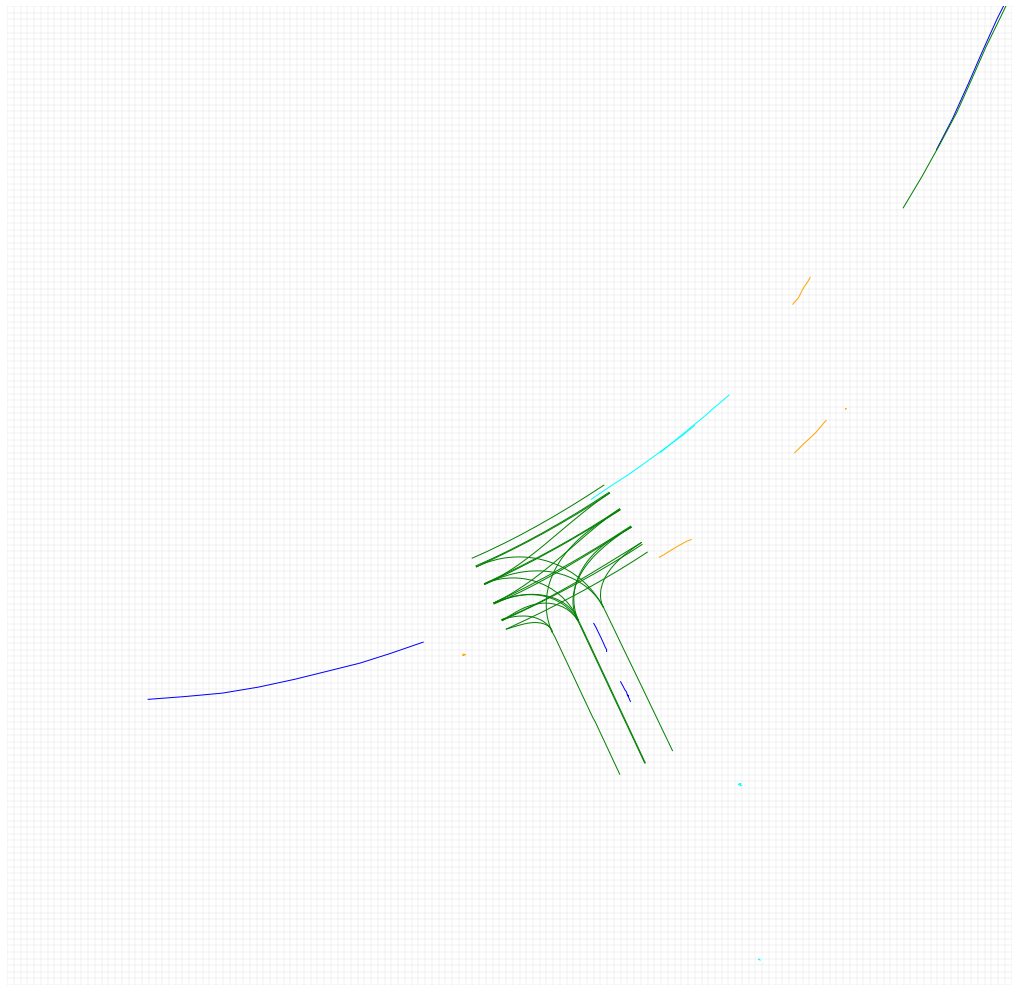

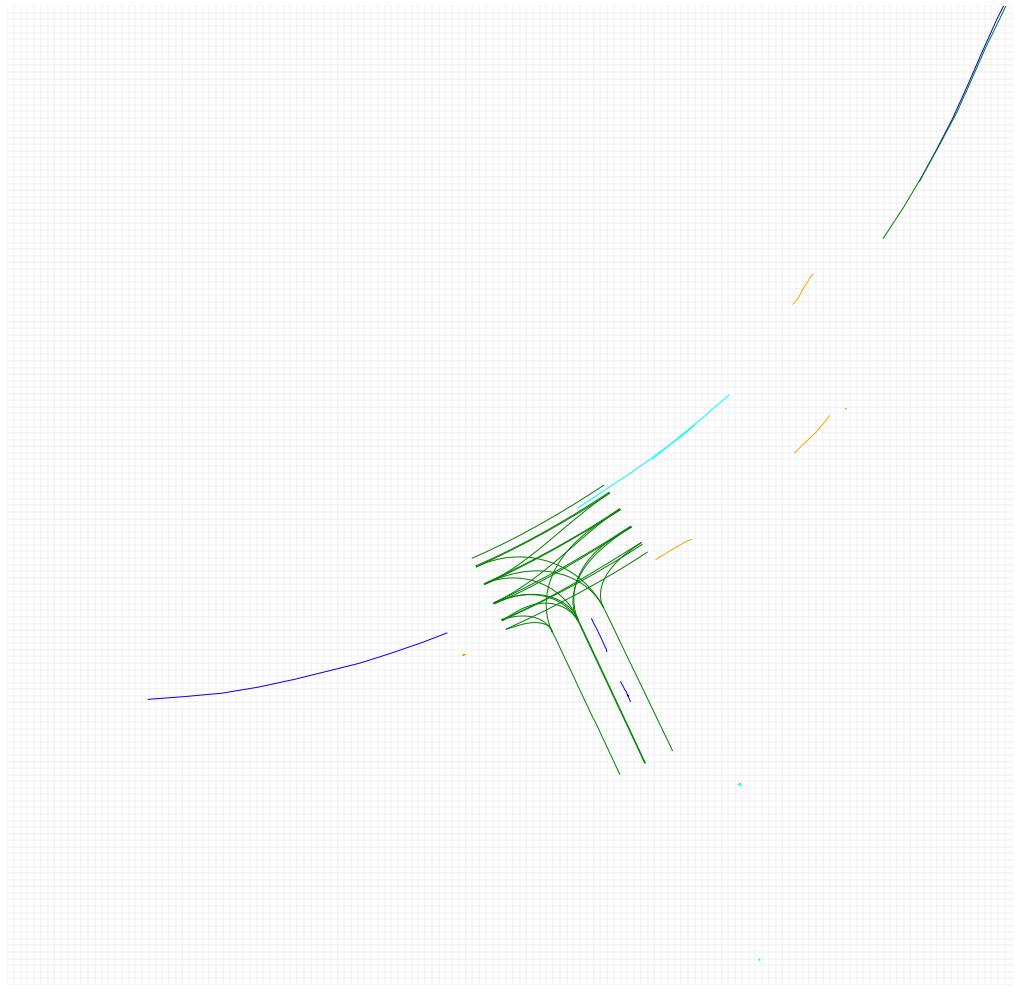

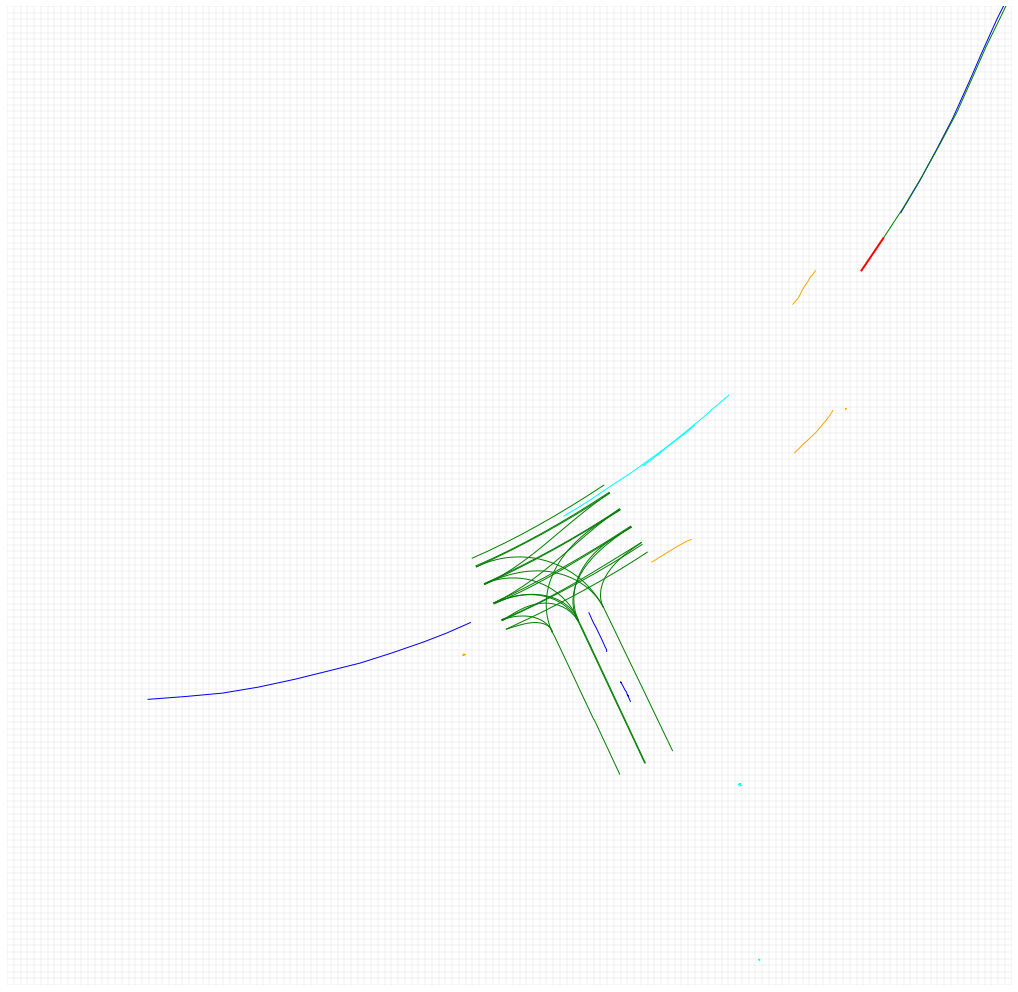

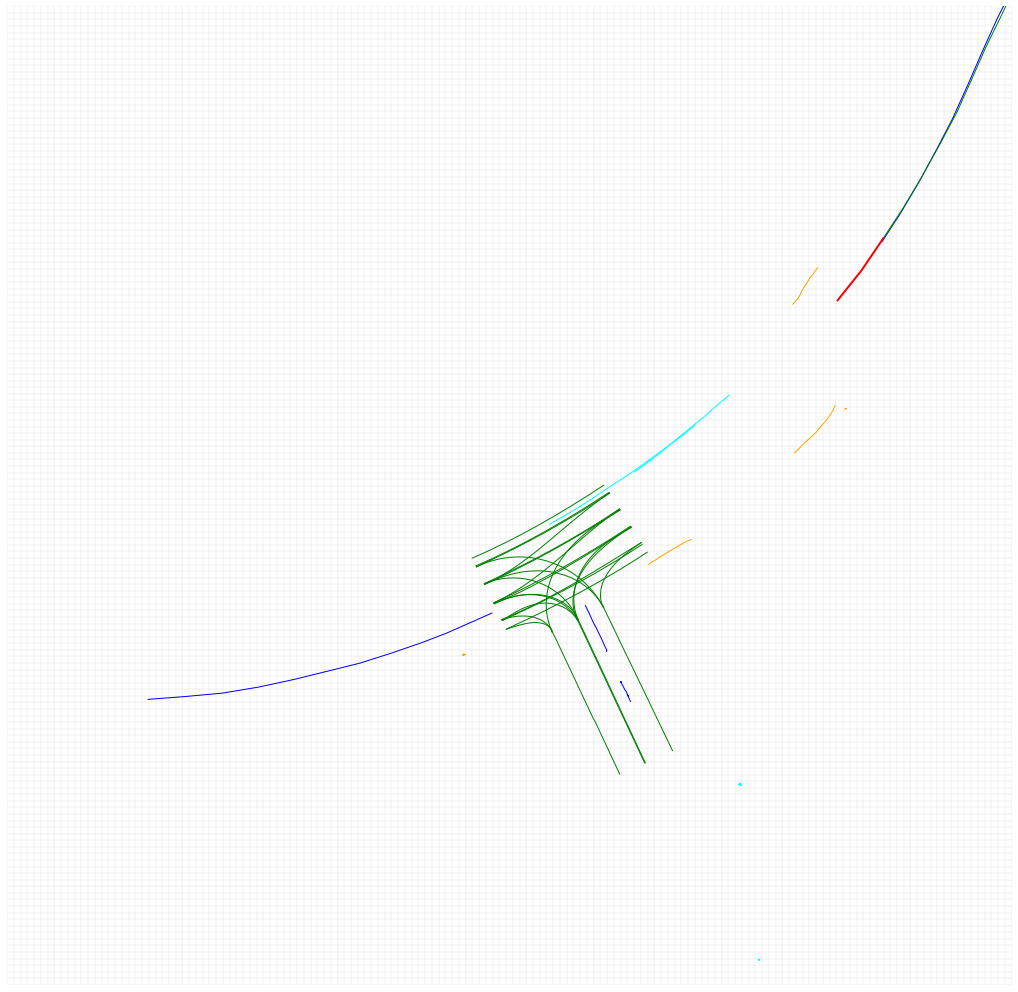

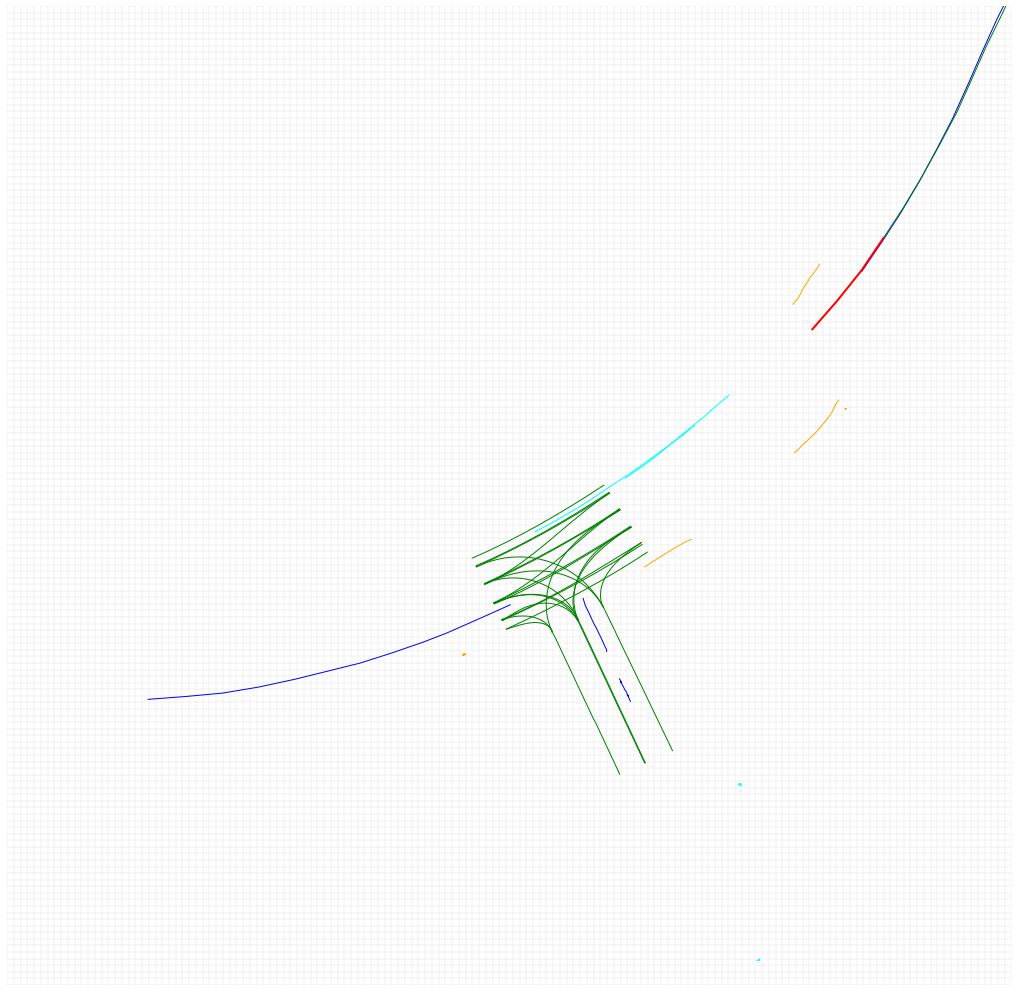

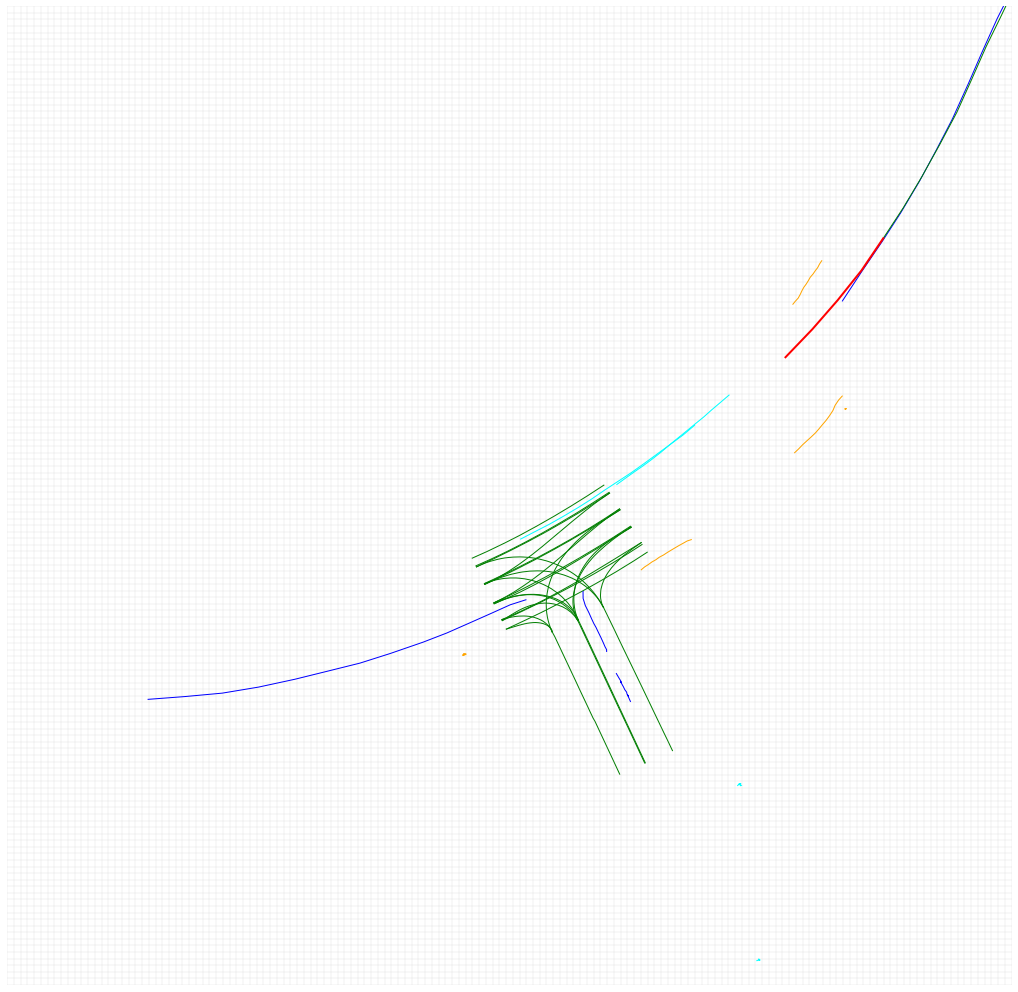

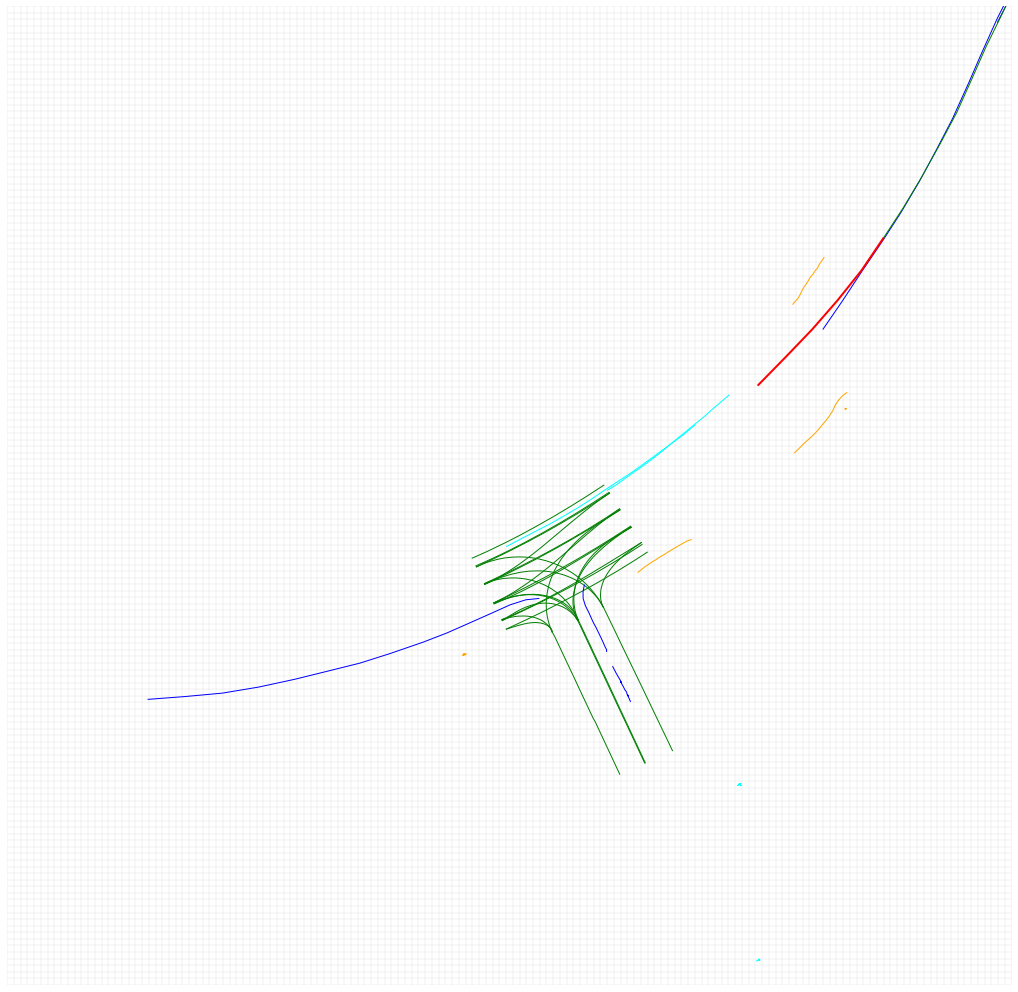

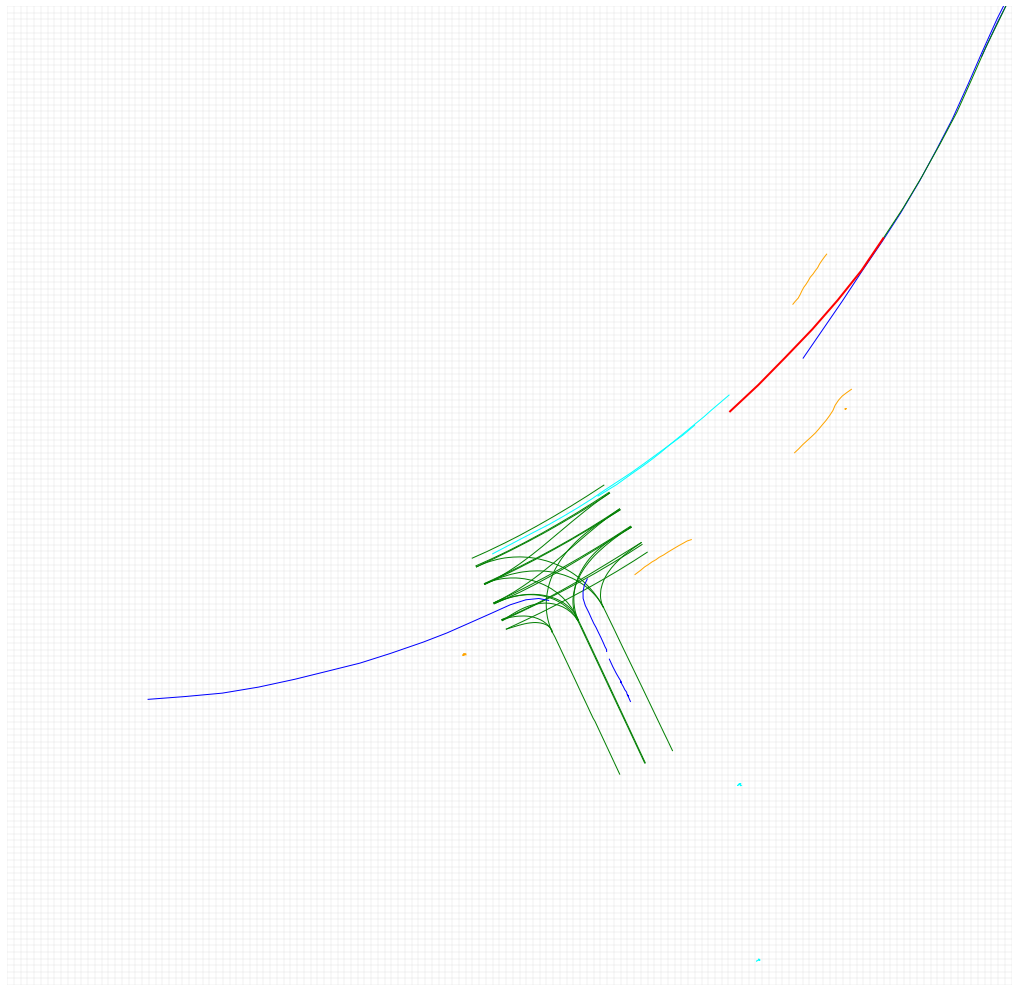

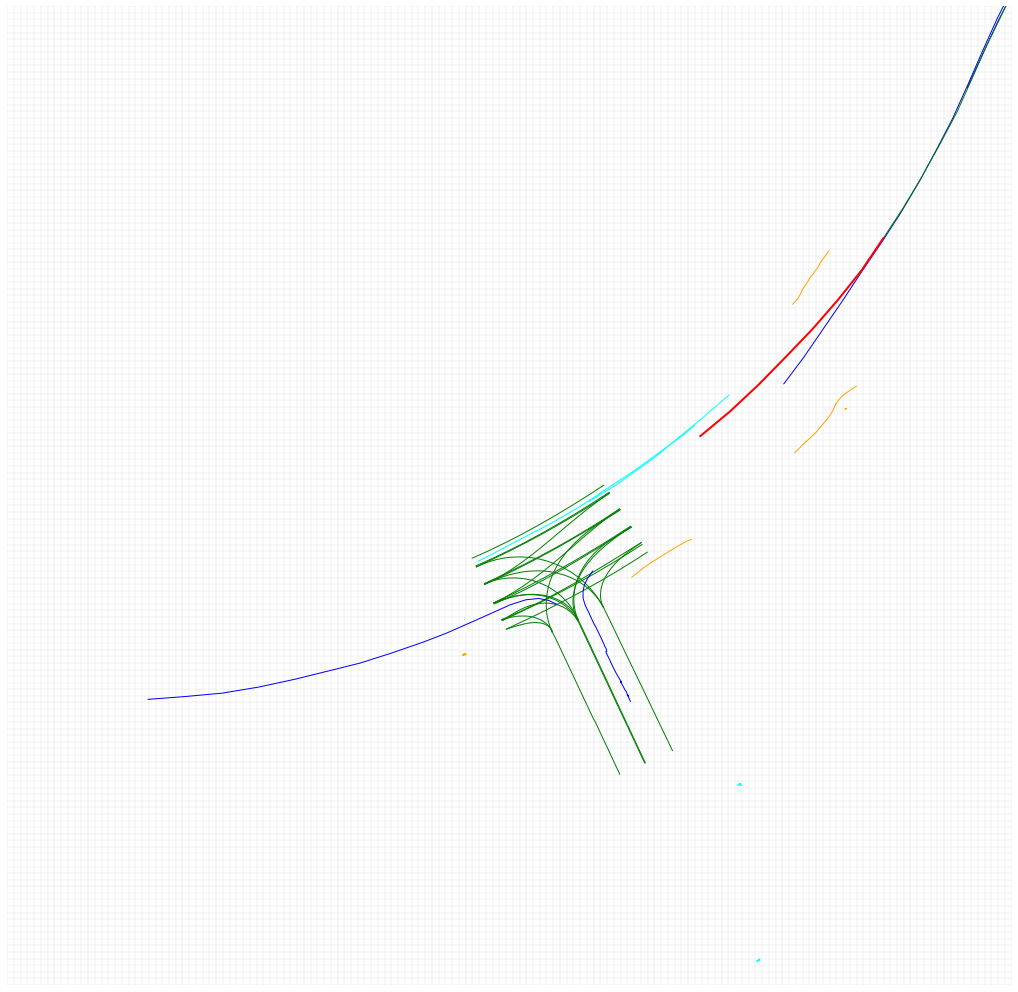

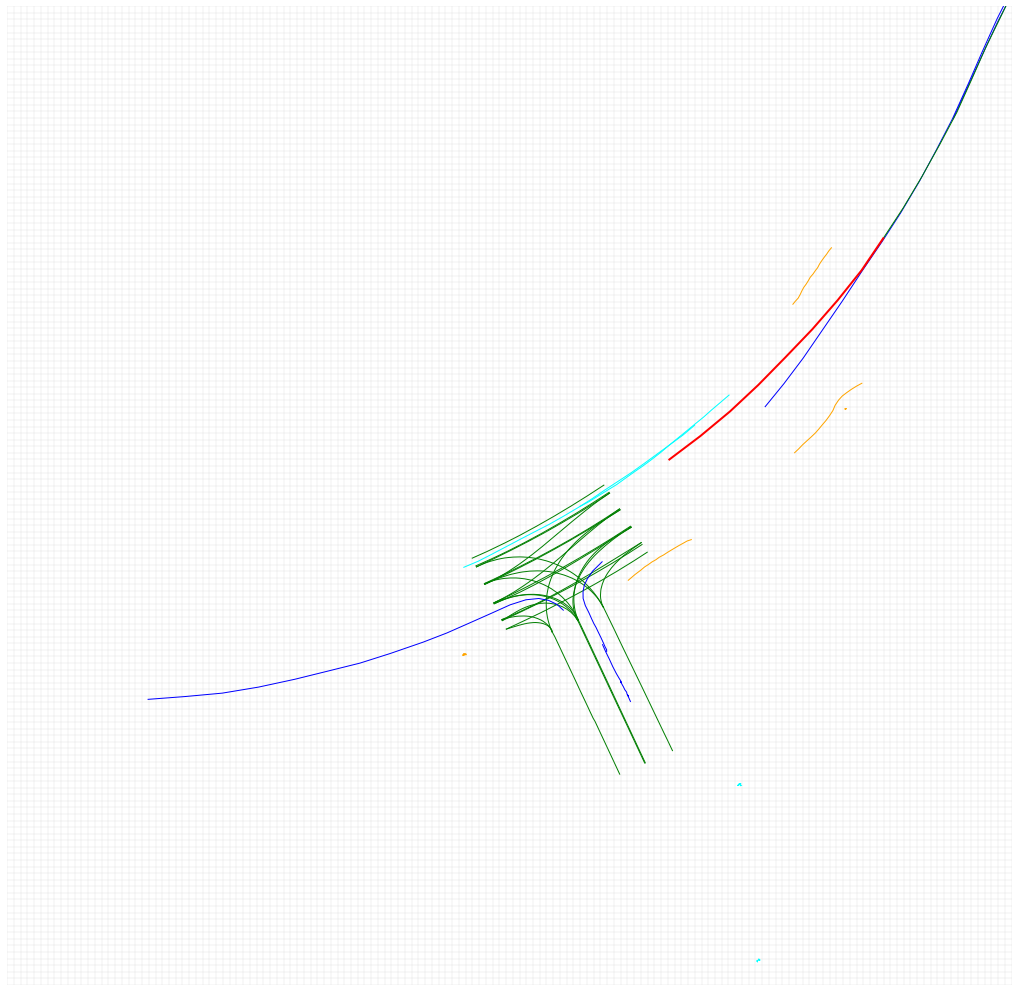

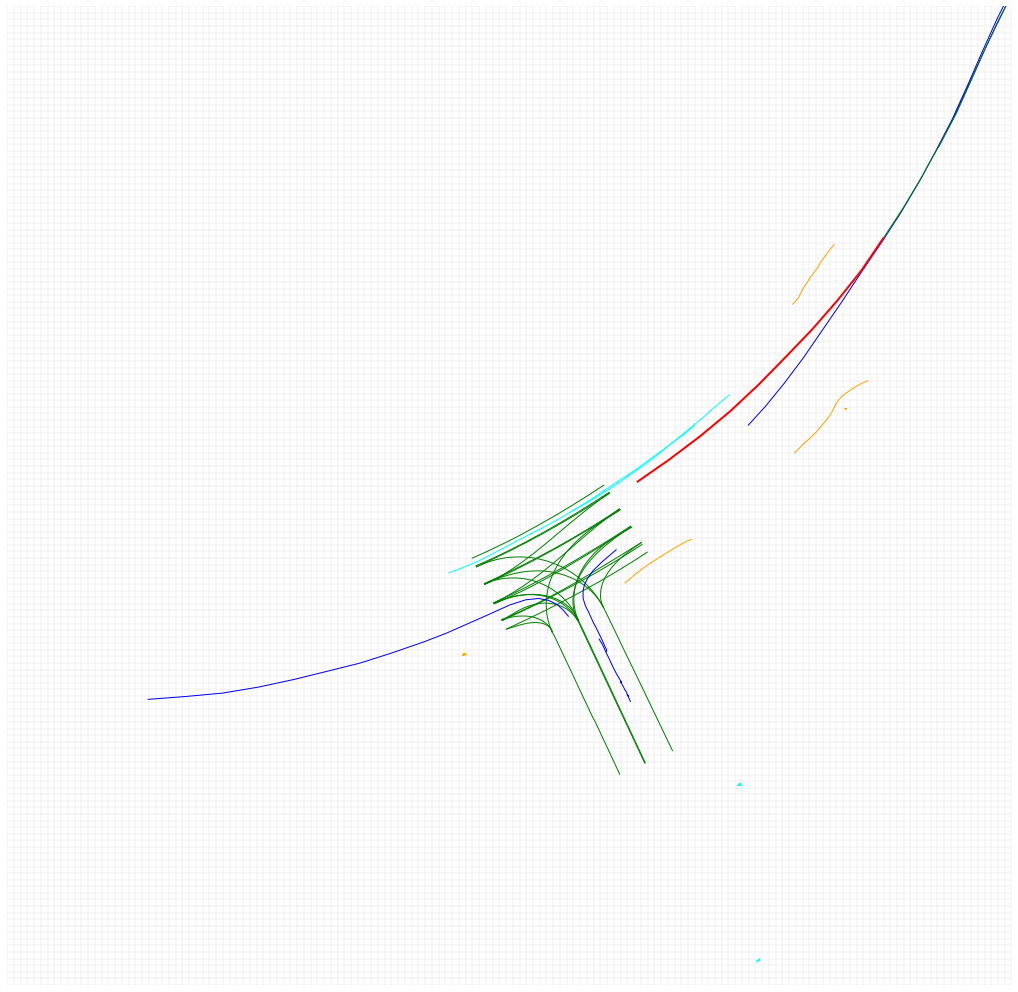

In [181]:
animate_planned_on_grid('8KfB', lane_list=lane_list, \
                            grid_boundary=grid_boundary, veh=sample['veh'][1:], ped=sample['ped'], cyc=sample['cyc'],\
                      target_obs=target_obs, planned=target_planned)              
